## Imporerer pakker

In [1]:
import pandas as pd
import numpy as np



# Model Selection and Evaluation
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import root_mean_squared_error, r2_score, accuracy_score, f1_score, log_loss, confusion_matrix

from sklearn.compose import TransformedTargetRegressor

# Regression Models
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor, HistGradientBoostingRegressor, AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from catboost import CatBoostRegressor


# Classification Models
from sklearn.linear_model import LogisticRegression, HuberRegressor, BayesianRidge, LassoLars, PassiveAggressiveRegressor, TheilSenRegressor, SGDRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC

# Other Model Utilities
from sklearn.dummy import DummyRegressor
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.tree import plot_tree

from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics import make_scorer
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
import matplotlib.pyplot as plt
from sklearn import set_config
import plotly.express as px
from sklearn.compose import TransformedTargetRegressor
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.compose import TransformedTargetRegressor
from scipy import stats
from xgboost import XGBRegressor
from sklearn.preprocessing import TargetEncoder
import shap
from sklearn.preprocessing import MinMaxScaler
import pickle

/Users/jakobberg/anaconda3/envs/INF161/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Laster inn filer

In [2]:
train_df = pd.read_csv('train_df.csv')
val_df = pd.read_csv('validation_df.csv')
test_df = pd.read_csv('test_df.csv')

pd.set_option('display.max_columns', None)
pd.reset_option('display.float_format')

# Variabelutvinning

## Klassifikasjonsmodell for sykehusdød

In [5]:
# Forbered trenings- og valideringsdatasett
from preprocessing import prepare_data_for_death_classification, get_col_transformer
# Step 1: Train and save the classification model for imputing `sykehusdød`

# Prepare training and validation datasets for classification
X_train_classification, numeric_cols, categorical_cols, y_train = prepare_data_for_death_classification(train_df)
X_val_classification, _, _, y_val = prepare_data_for_death_classification(val_df)
X_test_classification, _, _, y_test = prepare_data_for_death_classification(test_df)

# Set up ColumnTransformer and classification pipeline
preprocessor = get_col_transformer(numeric_cols, categorical_cols)
classification_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Train the classifier
classification_pipeline.fit(X_train_classification, y_train)

# Validate and save the model
y_val_pred = classification_pipeline.predict(X_val_classification)
accuracy = accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy: {accuracy:.2f}")

y_test_pred = classification_pipeline.predict(X_test_classification)
accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy: {accuracy:.2f}")
# Save the classification model for future use
with open('sykehusdod_model.pkl', 'wb') as f:
    pickle.dump(classification_pipeline, f)

Validation Accuracy: 0.85
Test Accuracy: 0.81


In [6]:
if 'sykehusdød' in val_df.columns:
    val_df = val_df.drop(columns=['sykehusdød'])
if 'sykehusdød' in test_df.columns:
    test_df = test_df.drop(columns=['sykehusdød'])
# Prepare data for classification and predict `sykehusdød`
X_val_classification, _, _, _ = prepare_data_for_death_classification(val_df, prediction_mode=True)
X_test_classification, _, _, _ = prepare_data_for_death_classification(test_df, prediction_mode=True)

# Impute `sykehusdød`
val_df['sykehusdød'] = classification_pipeline.predict(X_val_classification)
test_df['sykehusdød'] = classification_pipeline.predict(X_test_classification)


## Oppretter nye variabler, og splitter target/features

In [5]:
from preprocessing import prepare_data_for_length_prediction

# Step 1: Prepare the data for length prediction
X_train, numeric_cols_train, categorical_cols_train, y_train = prepare_data_for_length_prediction(train_df, prediction_mode=False)
X_val, numeric_cols_val, categorical_cols_val, y_val = prepare_data_for_length_prediction(val_df, prediction_mode=False)
X_test, numeric_cols_test, categorical_cols_test, y_test = prepare_data_for_length_prediction(test_df, prediction_mode=False)

## Imputerer manglende verdier og oneHotEncoder kategoriske variabler

In [6]:

# We use the `numeric_cols_train` and `categorical_cols_train` from the prepare_data_for_length_prediction function
col_transformer = get_col_transformer(numeric_cols_train, categorical_cols_train)

# Step 3: Fit and transform the training data
X_train_imputed = col_transformer.fit_transform(X_train)

# Step 4: Transform the validation and test data
X_val_imputed = col_transformer.transform(X_val)
X_test_imputed = col_transformer.transform(X_test)

# Step 5: Get feature names (numeric and one-hot encoded categorical columns)
numeric_feature_names = numeric_cols_train  # Use the numeric columns from training
categorical_feature_names = col_transformer.named_transformers_['cat_pipeline']\
    .named_steps['one-hot-encoder'].get_feature_names_out(categorical_cols_train)

# Combine numeric and categorical feature names
feature_names = list(numeric_feature_names) + list(categorical_feature_names)

# Step 6: Convert the transformed data back into DataFrames with the correct column names
X_train_imputed = pd.DataFrame(X_train_imputed, columns=feature_names)
X_val_imputed = pd.DataFrame(X_val_imputed, columns=feature_names)
X_test_imputed = pd.DataFrame(X_test_imputed, columns=feature_names)


## Grunnlinjemodeller

In [7]:
baseline = DummyRegressor(strategy='mean')
baseline.fit(X_train, y_train)
prediction = baseline.predict(X_val)
rmse_baseline = root_mean_squared_error(y_val, prediction)
rmse_baseline

21.59611100410102

In [8]:
baseline2 = DummyRegressor(strategy='median')
baseline2.fit(X_train, y_train)
prediction = baseline2.predict(X_val)
rmse_baseline = root_mean_squared_error(y_val, prediction)
rmse_baseline

22.712103715253104

## Modellering

## Visualisering av actual vs predicted

In [9]:
def plot_actual_vs_pred(y_actual, y_pred, model_name):
    df = pd.DataFrame({'Actual': y_actual, 'Predicted': y_pred})
    fig = px.scatter(df, x='Actual', y='Predicted', title=f"{model_name}: Actual vs. Predicted")
    fig.add_shape(type="line", x0=df['Actual'].min(), y0=df['Actual'].min(),
                  x1=df['Actual'].max(), y1=df['Actual'].max(), line=dict(color='Red', dash='dash'))
    fig.show()


## RandomForestRegression

In [10]:
model_rf = RandomForestRegressor(random_state=42)
model_rf.fit(X_train_imputed, y_train)

# Evaluate the model on validation data
y_val_pred_rf = model_rf.predict(X_val_imputed)
rmse_val_rf = (root_mean_squared_error(y_val, y_val_pred_rf))
print(f"RMSE on Validation Set (RandomForest): {rmse_val_rf:.3f}")
plot_actual_vs_pred(y_val, y_val_pred_rf, "Random Forest with Target Encoding")

RMSE on Validation Set (RandomForest): 20.714


## ExtraTreesRegressor

In [11]:
# Define and train ExtraTrees model
model_et = ExtraTreesRegressor(random_state=42)
model_et.fit(X_train_imputed, y_train)

# Evaluate on validation data
y_val_pred_et = model_et.predict(X_val_imputed)
rmse_val_et = (root_mean_squared_error(y_val, y_val_pred_et))
print(f"RMSE on Validation Set (ExtraTrees): {rmse_val_et:.3f}")
plot_actual_vs_pred(y_val, y_val_pred_et, "Random Forest with Target Encoding")

RMSE on Validation Set (ExtraTrees): 20.476


## Ridge

In [12]:
# Define and train ExtraTrees model
model_gb = Ridge(random_state=42)
model_gb.fit(X_train_imputed, y_train)

# Evaluate on validation data
y_val_pred_gb = model_gb.predict(X_val_imputed)
rmse_val_gb = (root_mean_squared_error(y_val, y_val_pred_gb))
print(f"RMSE on Validation Set (ExtraTrees): {rmse_val_gb:.3f}")
plot_actual_vs_pred(y_val, y_val_pred_gb, "Random Forest with Target Encoding")

RMSE on Validation Set (ExtraTrees): 20.498


In [29]:
from sklearn.model_selection import RandomizedSearchCV

X_train_full = X_train_imputed
X_val_full = X_val_imputed

# Define the parameter grid for ExtraTreesRegressor
param_grid_et = {
    'n_estimators': [100, 200, 500],  # Number of trees
    'max_depth': [10, 20, 50, None],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],    # Minimum samples required to be at a leaf node
    'bootstrap': [True, False]        # Whether bootstrap samples are used when building trees
}

# Initialize RandomizedSearchCV for ExtraTreesRegressor
random_search_et = RandomizedSearchCV(
    estimator=ExtraTreesRegressor(random_state=42),
    param_distributions=param_grid_et,
    n_iter=50,  # Number of random parameter combinations to try
    cv=5,  # 5-fold cross-validation
    scoring='neg_root_mean_squared_error',
    verbose=2,
    random_state=42,
    n_jobs=-1  # Use all available cores
)

# Fit the random search model on the full feature set (X_train_full)
random_search_et.fit(X_train_full, y_train)

# Best hyperparameters
print(f"Best Hyperparameters: {random_search_et.best_params_}")

# Best RMSE score
best_rmse = -random_search_et.best_score_
print(f"Best RMSE Score: {best_rmse:.3f}")

# After finding the best model, use it to predict on the validation set
best_et_model = random_search_et.best_estimator_

# Predict on the validation set (with full features)
y_val_pred_best_et = best_et_model.predict(X_val_full)

# Calculate RMSE for the full feature set
rmse_best_et = root_mean_squared_error(y_val, y_val_pred_best_et)
print(f"RMSE on Validation Set with Full Features: {rmse_best_et:.3f}")

# Call the plot_actual_vs_pred function to visualize actual vs predicted values
plot_actual_vs_pred(y_val, y_val_pred_best_et, "Best ExtraTreesRegressor with Full Features")


Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END bootstrap=False, max_depth=None, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   3.5s
[CV] END bootstrap=False, max_depth=None, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   3.6s
[CV] END bootstrap=False, max_depth=None, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   3.6s
[CV] END bootstrap=False, max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   4.8s
[CV] END bootstrap=False, max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   4.8s
[CV] END bootstrap=False, max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   4.8s
[CV] END bootstrap=False, max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   4.8s
[CV] END bootstrap=False, max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators

In [31]:
from sklearn.model_selection import GridSearchCV

# Use the best parameters as the center of the grid
param_grid_et_refined = {
    'n_estimators': [150, 200, 250],  # Around 200
    'max_depth': [40, 50, 60],        # Around 50
    'min_samples_split': [2, 3, 4], # Around 10
    'min_samples_leaf': [3, 4, 5],    # Around 4
    'bootstrap': [True]               # Keep as True based on RandomizedSearch result
}

# Initialize GridSearchCV for ExtraTreesRegressor
grid_search_et = GridSearchCV(
    estimator=ExtraTreesRegressor(random_state=42),
    param_grid=param_grid_et_refined,
    cv=5,  # 5-fold cross-validation
    scoring='neg_root_mean_squared_error',
    verbose=2,
    n_jobs=-1  # Use all available cores
)

# Fit the grid search model on the full feature set (X_train_full)
grid_search_et.fit(X_train_full, y_train)

# Best hyperparameters from GridSearch
print(f"Best Hyperparameters from GridSearch: {grid_search_et.best_params_}")

# Best RMSE score from GridSearch
best_rmse_grid = -grid_search_et.best_score_
print(f"Best RMSE Score from GridSearch: {best_rmse_grid:.3f}")

# After finding the best model, use it to predict on the validation set
best_et_model_grid = grid_search_et.best_estimator_

# Predict on the validation set (with full features)
y_val_pred_best_et_grid = best_et_model_grid.predict(X_val_full)

# Calculate RMSE for the full feature set
rmse_best_et_grid = root_mean_squared_error(y_val, y_val_pred_best_et_grid)
print(f"RMSE on Validation Set with Full Features (GridSearch): {rmse_best_et_grid:.3f}")

# Visualize actual vs predicted values
plot_actual_vs_pred(y_val, y_val_pred_best_et_grid, "Best ExtraTreesRegressor with Full Features (GridSearch)")



Fitting 5 folds for each of 81 candidates, totalling 405 fits
[CV] END bootstrap=True, max_depth=40, min_samples_leaf=3, min_samples_split=2, n_estimators=150; total time=   4.2s
[CV] END bootstrap=True, max_depth=40, min_samples_leaf=3, min_samples_split=2, n_estimators=150; total time=   4.2s
[CV] END bootstrap=True, max_depth=40, min_samples_leaf=3, min_samples_split=2, n_estimators=150; total time=   4.2s
[CV] END bootstrap=True, max_depth=40, min_samples_leaf=3, min_samples_split=2, n_estimators=150; total time=   4.2s
[CV] END bootstrap=True, max_depth=40, min_samples_leaf=3, min_samples_split=2, n_estimators=150; total time=   4.2s
[CV] END bootstrap=True, max_depth=40, min_samples_leaf=3, min_samples_split=2, n_estimators=200; total time=   5.4s
[CV] END bootstrap=True, max_depth=40, min_samples_leaf=3, min_samples_split=2, n_estimators=200; total time=   5.5s
[CV] END bootstrap=True, max_depth=40, min_samples_leaf=3, min_samples_split=2, n_estimators=200; total time=   5.5s
[C

In [30]:
with open('model.pkl', 'wb') as f:
    pickle.dump((best_et_model_grid, col_transformer, feature_names), f)

In [31]:
# Get feature importances from the best model after GridSearch
importances = best_et_model_grid.feature_importances_

# Create a DataFrame to display feature importances with the correct features
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,  # Use the feature names from X_train_full
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Display the top features
feature_importance_df.T


,36,16,17,15,0,18,14,10,19,4,2,8,6,5,12,11,7,3,1,13,9,20,22,46,21,26,48,25,32,47,23,31,34,50,28,51,29,33,37,27,38,49,24,35,41,39,43,30,44,45,42,40
Feature,sykdom_underkategori_ARF/MOSF w/Sepsis,overlevelsesestimat_2mnd,overlevelsesestimat_6mnd,apache_fysiologisk_score,alder,lege_overlevelsesestimat_2mnd,fysiologisk_score,natrium,lege_overlevelsesestimat_6mnd,hjertefrekvens,blodtrykk,serumalbumin,kroppstemperatur,respirasjonsfrekvens,antall_komorbiditeter,blod_ph,lungefunksjon,hvite_blodlegemer,utdanning,koma_score,kreatinin,diabetes,blodurea_nitrogen,inntekt_8.0,glukose,kjønn_male,inntekt_35.0,kjønn_female,sykdomskategori_ARF/MOSF,inntekt_20.0,urinmengde,etnisitet_white,sykdomskategori_Cancer,kreft_no,etnisitet_black,kreft_yes,etnisitet_hispanic,sykdomskategori_COPD/CHF/Cirrhosis,sykdom_underkategori_CHF,etnisitet_asian,sykdom_underkategori_COPD,kreft_metastatic,demens,sykdomskategori_Coma,sykdom_underkategori_Coma,sykdom_underkategori_Cirrhosis,sykdom_underkategori_MOSF w/Malig,etnisitet_other,dnr_status_dnr før innleggelse,dnr_status_dnr ved innleggelse,sykdom_underkategori_Lung Cancer,sykdom_underkategori_Colon Cancer
Importance,0.158306,0.049716,0.045818,0.041502,0.039932,0.037981,0.034327,0.03284,0.031395,0.031299,0.030842,0.029286,0.027932,0.027258,0.02536,0.024937,0.024414,0.024205,0.024154,0.022261,0.021708,0.01568,0.015101,0.015058,0.013977,0.012896,0.012869,0.012804,0.012799,0.012566,0.012314,0.011767,0.010247,0.008368,0.0076,0.006076,0.004895,0.004845,0.00387,0.003831,0.002757,0.002666,0.002386,0.001779,0.001543,0.001485,0.001211,0.000747,0.000734,0.000704,0.000624,0.000326


## Log-Transformasjon på target data

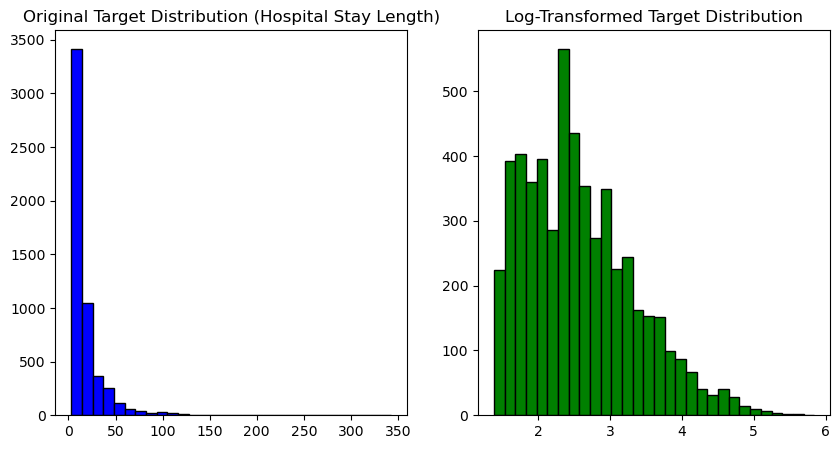

In [32]:
plt.figure(figsize=(10, 5))

# Histogram of original target values
plt.subplot(1, 2, 1)
plt.hist(y_train, bins=30, color='blue', edgecolor='black')
plt.title('Original Target Distribution (Hospital Stay Length)')

# Histogram of log-transformed target values
plt.subplot(1, 2, 2)
plt.hist(np.log1p(y_train), bins=30, color='green', edgecolor='black')
plt.title('Log-Transformed Target Distribution')

plt.show()

In [33]:
# Log transformation of the target variable (log(1 + x) to handle zero values)
y_train_log = np.log1p(y_train)
y_val_log = np.log1p(y_val)

# Fit the best ExtraTrees model on the log-transformed target
best_et_model.fit(X_train_imputed, y_train_log)

# Predict on the validation set
pred_log = best_et_model.predict(X_val_imputed)

# Inverse transformation (exp to bring predictions back to original scale)
pred_original_scale = np.expm1(pred_log)

# Calculate RMSE on the original scale
rmse = (root_mean_squared_error(y_val, pred_original_scale))
print(f"RMSE with log transformation: {rmse:.3f}")

# Plot actual vs predicted values
plot_actual_vs_pred(y_val, pred_original_scale, "ExtraTrees with Log Transformation")


RMSE with log transformation: 20.761


## Forsøker å trene modellen på ved å fjerne ekstreme uteliggere med over 95% 

## TODO: Fortsette å teste med flere variable, eventuelt forsøke å fjerne noen. Analysere RMSE, for å finne ut hvorfor den er som den er. Er det mulig at modellen er god, men at den misser stort på uteliggere?